In [98]:
%matplotlib inline
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_distribution, array_to_latex, plot_bloch_multivector
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import pandas as pd
import seaborn as sns

![diagram](./assets/buckshot-roulette-diagram.png)

In [113]:
class Person(Player):
    def play(
        self, 
        gun:Shotgun,
        removed_blank:int, 
        removed_full:int,
        oponent:Player
    ) -> (str, int):
        
        action = None
        result = None
        
        if(gun.total_full > gun.total_blank):
            result = gun.shoot(oponent)
            action = "shoot"
        else:
            result = gun.shoot(self)
            action = "himself"
        
        """
        if(np.random.randint(0,2)):
            result = gun.shoot(oponent)
            action = "shoot"
        else:
            result = gun.shoot(self)
            action = "himself"
        """
        self.update_actions(action)
        return action, result

In [114]:
class Dealer(Player):
    def play(
        self, 
        gun:Shotgun,
        removed_blank:int, 
        removed_full:int,
        oponent:Player
    ) -> str:

        action = None
        result = None
        
        if(np.random.randint(0,2)):
            result = gun.shoot(oponent)
            action = "shoot"
        else:
            result = gun.shoot(self)
            action = "himself"
        self.update_actions(action)
        return action, result

In [126]:
class Game:
    gun = None
    removed_blank = 0
    removed_full = 0
    total_full = 0
    total_blank = 0
    total_rounds = 0
    player = None 
    dealer = None 
    next_player = None
    n = 0
    invert = False
    statistics = None
    player_class_strategy = None
    
    
    def __init__(self, n:int, total_full:int, total_blank:int, invert:bool=False, player:Player=Person):
        self.total_full = total_full
        self.total_blank = total_blank
        self.total_rounds = total_full+total_blank
        self.n = n
        self.invert = invert
        self.statistics = pd.DataFrame(columns=("player_win", "dealer_win", "total_rounds"))
        self.statistics.reset_index()
        self.player_class_strategy = player

    def start_actors(self):
        self.gun = Shotgun(self.total_full, self.total_blank)
        self.player = self.player_class_strategy("player")
        self.dealer = Dealer("dealer")
        self.removed_full = 0
        self.removed_blank = 0
        
        if(self.invert):
            self.next_player = self.dealer
        else:
            self.next_player = self.player


    def run_game(self) -> pd.DataFrame:
        for i in range(self.n):
            self.start_actors()
            for round in range(self.total_rounds):
                #print(f"round {round}: ", end=" ")
                action, result = self.next_player.play(self.gun, self.removed_blank, self.removed_full, self.get_oponent())
    
                if(result == "blank"):
                    self.removed_blank += 1
                else:
                    self.removed_full += 1
                
                #print(f"{self.next_player.name} --> {action}, {result}")
    
                if(action != "himself"):
                    self.next_player = self.get_oponent()
                #print(self.player.total_life_lost, self.dealer.total_life_lost, self.total_full)
                
                if(self.player.total_life_lost == self.total_full):
                    #print("dealer wins")
                    self.statistics.loc[i] = {'dealer_win':1, 'player_win':0, 'total_rounds':round}                    
                    break
                elif(self.dealer.total_life_lost == self.total_full):
                    #print("player wins")
                    self.statistics.loc[i] = {'dealer_win':0, 'player_win':1, 'total_rounds':round}                    
                    break

                if(self.total_full == self.removed_full):
                    #print("done full bullets")
                    break
            #print()
        return self.statistics
            

    def get_oponent(self):
        if(self.next_player == self.player):
            return self.dealer
        else:
            return self.player

results = Game(100, 1,2).run_game()
results.head()

,player_win,dealer_win,total_rounds
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,2
4,1,0,2


In [97]:
print(len(results[results['player_win'] == 1]), len(results[results['dealer_win'] == 1]))

54 46


In [129]:
def compare_game_run(game:Game, n:int=100) -> pd.DataFrame:
    total = pd.DataFrame(columns=("total_player", "total_dealer"))
    total.reset_index()
    
    total_win = lambda results, target: len(results[results[target] == 1]) 
    
    for i in range(n):
        result = game.run_game()
        total.loc[i] = {"total_player":total_win(result, "player_win"), "total_dealer":total_win(result, "dealer_win")}
    return total

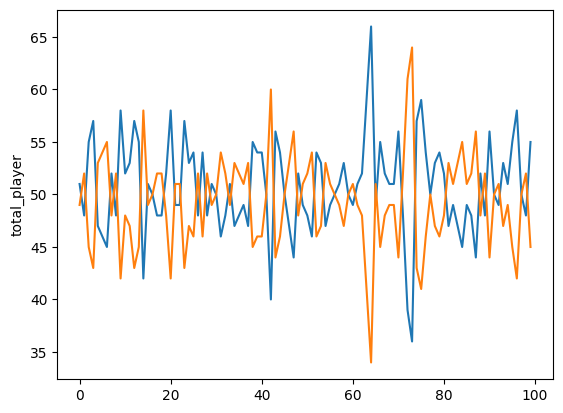

In [141]:
total = compare_game_run(Game(100, 1, 2))
sns.lineplot(data=total, x=total.index.tolist(), y="total_player")
sns.lineplot(data=total, x=total.index.tolist(), y="total_dealer")
plt.show()

In [142]:
sum(total["total_player"]), sum(total["total_dealer"])

(5075, 4925)

In [125]:
class Person2(Player):
    def play(
        self, 
        gun:Shotgun,
        removed_blank:int, 
        removed_full:int,
        oponent:Player
    ) -> (str, int):
        
        action = None
        result = None
        
        if(np.random.randint(0,2)):
            result = gun.shoot(oponent)
            action = "shoot"
        else:
            result = gun.shoot(self)
            action = "himself"

        self.update_actions(action)
        return action, result

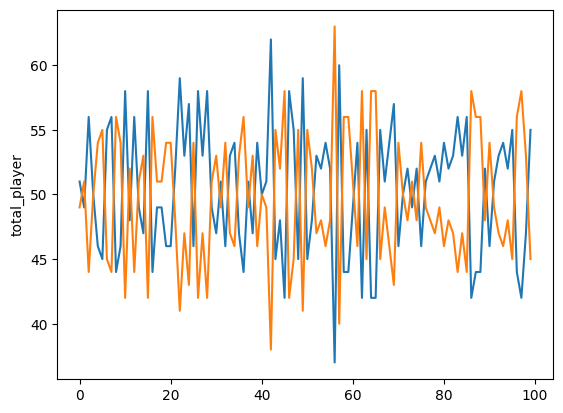

In [131]:
total = compare_game_run(Game(100, 1, 2, player=Person2))
sns.lineplot(data=total, x=total.index.tolist(), y="total_player")
sns.lineplot(data=total, x=total.index.tolist(), y="total_dealer")
plt.show()

In [134]:
sum(total["total_player"]), sum(total["total_dealer"])

(5039, 4961)